In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
cells_kpis = pd.read_csv("/data/u_AA/throughput_opt/4G_CELLS_BH_KPIS.csv")
cells_params = pd.read_csv('/data/u_AA/throughput_opt/DSP_H_CELLS_PARAMTERS_EXTRACT.csv')


In [4]:
all_df = pd.merge(cells_kpis, cells_params, on = 'CELL_NAME')
all_df.drop(['DATE_ID_x', 'HOUR_ID_x', 'DATE_ID_y', 'HOUR_ID_y', 'SITE_ID', 'SITE_NENAME',
       'CELL_ID', 'MIMO_ADAPTIVE_SWITCH', 'FIXED_MIMO_MODE',  'ULBANDWIDTH','SPECTRUMCLOUDSWITCH'], axis = 1, inplace = True)
all_df.head()

,CELL_NAME,DL_TRAFFIC_GB,DL_THROUGHPUT,UL_THROUGHPUT,UL_TRAFFIC_GB,DL_PRB_UTI,CCE_UTI,VOLTE_DL_TRAFFIC_ERL,VOLTE_DL_TRAFFIC_MB,VOLTE_UL_TRAFFIC_MB,AVG_ACTIVE_UE_DL,MAXMIMORANKPARA,REFERENCESIGNALPWR,PB,DLBANDWIDTH,PAPCOFF,MAXIMUM_TRANSMIT_POWER
0,LALX3634_56348_N_H_T8-3,0.0063,3.1673,3.1308,0.0024,2.308,3.75,0.00,0.00,0.00,0.178,Rank4,152,1,20M,0.0,430.0
1,LALX3639_56396_N_H_T8-1,1.9485,21.0800,3.3449,0.2171,19.851,14.19,1.04,5.04,5.52,22.403,Rank4,182,1,20M,0.0,460.0
2,LALX3642_36426_N_H_G2-1,0.0000,0.0000,0.0000,0.0000,2.304,7.19,0.00,0.00,0.00,0.000,Rank2,182,0,10M,0.0,490.0
3,LALX3642_56421_S_H_D4-3,0.0000,0.0000,0.0000,0.0000,0.000,0.00,0.00,0.00,0.00,0.000,Rank2,152,0,20M,0.0,460.0
4,LALX3644_36441_N_H_D4-1,0.6732,41.8595,4.4317,0.0422,4.494,5.85,0.03,0.10,0.19,2.627,Rank2,170,0,20M,0.0,478.0


In [5]:
all_df['CELL_NAME'] = all_df['CELL_NAME'].str.replace('-', '_')


In [6]:
all_df['band'] = all_df["CELL_NAME"].str.split('_').str.get(-2)
# all_df['band'] = all_df['band'].str.split('-').str.get(0)

In [7]:
all_df['band_letter'] = all_df['band'].str.get(0)

In [8]:
all_df.dropna(axis=0,inplace=True)

In [9]:
all_df.drop_duplicates(inplace=True)

In [38]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25615 entries, 0 to 25854
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CELL_NAME               25615 non-null  object 
 1   DL_TRAFFIC_GB           25615 non-null  float64
 2   DL_THROUGHPUT           25615 non-null  float64
 3   UL_THROUGHPUT           25615 non-null  float64
 4   UL_TRAFFIC_GB           25615 non-null  float64
 5   DL_PRB_UTI              25615 non-null  float64
 6   CCE_UTI                 25615 non-null  float64
 7   VOLTE_DL_TRAFFIC_ERL    25615 non-null  float64
 8   VOLTE_DL_TRAFFIC_MB     25615 non-null  float64
 9   VOLTE_UL_TRAFFIC_MB     25615 non-null  float64
 10  AVG_ACTIVE_UE_DL        25615 non-null  float64
 11  MAXMIMORANKPARA         25615 non-null  object 
 12  REFERENCESIGNALPWR      25615 non-null  int64  
 13  PB                      25615 non-null  int64  
 14  DLBANDWIDTH             25615 non-null

In [10]:
all_df[all_df['band'].str.len() != 2]

,CELL_NAME,DL_TRAFFIC_GB,DL_THROUGHPUT,UL_THROUGHPUT,UL_TRAFFIC_GB,DL_PRB_UTI,CCE_UTI,VOLTE_DL_TRAFFIC_ERL,VOLTE_DL_TRAFFIC_MB,VOLTE_UL_TRAFFIC_MB,AVG_ACTIVE_UE_DL,MAXMIMORANKPARA,REFERENCESIGNALPWR,PB,DLBANDWIDTH,PAPCOFF,MAXIMUM_TRANSMIT_POWER,band,band_letter


In [11]:
all_df.isnull().sum()

CELL_NAME                 0
DL_TRAFFIC_GB             0
DL_THROUGHPUT             0
UL_THROUGHPUT             0
UL_TRAFFIC_GB             0
DL_PRB_UTI                0
CCE_UTI                   0
VOLTE_DL_TRAFFIC_ERL      0
VOLTE_DL_TRAFFIC_MB       0
VOLTE_UL_TRAFFIC_MB       0
AVG_ACTIVE_UE_DL          0
MAXMIMORANKPARA           0
REFERENCESIGNALPWR        0
PB                        0
DLBANDWIDTH               0
PAPCOFF                   0
MAXIMUM_TRANSMIT_POWER    0
band                      0
band_letter               0
dtype: int64

In [15]:
all_df[all_df['DL_PRB_UTI']==0].describe()

,DL_TRAFFIC_GB,DL_THROUGHPUT,UL_THROUGHPUT,UL_TRAFFIC_GB,DL_PRB_UTI,CCE_UTI,VOLTE_DL_TRAFFIC_ERL,VOLTE_DL_TRAFFIC_MB,VOLTE_UL_TRAFFIC_MB,AVG_ACTIVE_UE_DL,REFERENCESIGNALPWR,PB,PAPCOFF,MAXIMUM_TRANSMIT_POWER
count,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.000000,1204.000000,1204.000000,1204.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.335548,0.492525,0.003322,453.458472
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.776703,0.508394,0.172957,15.674657
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.000000,0.000000,-1.000000,393.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.000000,0.000000,0.000000,430.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.000000,0.000000,0.000000,460.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.000000,1.000000,0.000000,460.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.000000,3.000000,4.000000,490.000000


In [65]:
all_df[all_df['DL_THROUGHPUT']==0]

,CELL_NAME,DL_TRAFFIC_GB,DL_THROUGHPUT,UL_THROUGHPUT,UL_TRAFFIC_GB,DL_PRB_UTI,CCE_UTI,VOLTE_DL_TRAFFIC_ERL,VOLTE_DL_TRAFFIC_MB,VOLTE_UL_TRAFFIC_MB,AVG_ACTIVE_UE_DL,MAXMIMORANKPARA,REFERENCESIGNALPWR,PB,DLBANDWIDTH,PAPCOFF,MAXIMUM_TRANSMIT_POWER,band,band_letter
2,LALX3642_36426_N_H_G2_1,0.0,0.0,0.0,0.0,2.304,7.19,0.0,0.0,0.0,0.0,Rank2,182,0,10M,0.0,490.0,G2,G
3,LALX3642_56421_S_H_D4_3,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank2,152,0,20M,0.0,460.0,D4,D
12,LALX3657_76571_N_H_U1_1,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank2,182,0,5M,0.0,460.0,U1,U
16,LALX3662_36626_N_H_G2_1,0.0,0.0,0.0,0.0,1.958,6.22,0.0,0.0,0.0,0.0,Rank2,182,0,10M,0.0,490.0,G2,G
23,LALX3669_76691_N_H_U1_1,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank2,182,0,5M,0.0,460.0,U1,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25710,LUPP5589_45892_N_H_T4_2,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank4,192,1,20M,0.0,470.0,T4,T
25778,LDEL4590_55907_N_H_T8_2,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank4,192,1,20M,0.0,470.0,T8,T
25786,LDEL4672_46723_N_H_D6_3,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank2,162,0,20M,0.0,470.0,D6,D
25815,LUPP5906_49066_N_H_T8_1,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,Rank4,152,1,20M,0.0,430.0,T8,T


In [12]:
all_df=all_df[all_df['band'].str.len() == 2]

In [13]:
all_df.drop(all_df[all_df['DL_PRB_UTI'] == 0].index,inplace=True)

In [12]:
all_df[all_df['DL_THROUGHPUT']==0].describe()

,DL_TRAFFIC_GB,DL_THROUGHPUT,UL_THROUGHPUT,UL_TRAFFIC_GB,DL_PRB_UTI,CCE_UTI,VOLTE_DL_TRAFFIC_ERL,VOLTE_DL_TRAFFIC_MB,VOLTE_UL_TRAFFIC_MB,AVG_ACTIVE_UE_DL,REFERENCESIGNALPWR,PB,PAPCOFF,MAXIMUM_TRANSMIT_POWER
count,1850.000000,1850.0,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1845.0,1850.000000
mean,0.000001,0.0,0.014722,0.000001,4.445924,11.589389,0.000157,0.001335,0.001351,0.000298,182.450811,0.045405,0.0,473.550811
std,0.000038,0.0,0.140360,0.000041,3.199573,6.731243,0.003783,0.038876,0.040588,0.004253,7.152062,0.215899,0.0,19.577386
min,0.000000,0.0,0.000000,0.000000,0.766000,2.520000,0.000000,0.000000,0.000000,0.000000,122.000000,0.000000,0.0,400.000000
25%,0.000000,0.0,0.000000,0.000000,2.164000,6.770000,0.000000,0.000000,0.000000,0.000000,182.000000,0.000000,0.0,460.000000
50%,0.000000,0.0,0.000000,0.000000,2.935000,7.940000,0.000000,0.000000,0.000000,0.000000,182.000000,0.000000,0.0,490.000000
75%,0.000000,0.0,0.000000,0.000000,5.938250,20.112500,0.000000,0.000000,0.000000,0.000000,182.000000,0.000000,0.0,490.000000
max,0.001600,0.0,3.051800,0.001700,33.908000,39.560000,0.150000,1.640000,1.710000,0.160000,212.000000,3.000000,0.0,490.000000


In [14]:
categorical = all_df.select_dtypes(['object'])
numerical = all_df.select_dtypes(['float64','int64'])

In [15]:
encoded_categorical= pd.DataFrame()
for i in categorical.columns:
    frequency = categorical[i].value_counts(normalize=True)
    encoded_categorical[i] = categorical[i].map(frequency)

In [16]:
encoded_categorical

,CELL_NAME,MAXMIMORANKPARA,DLBANDWIDTH,band,band_letter
0,0.000041,0.365291,0.756241,0.142763,0.257819
1,0.000041,0.365291,0.756241,0.142763,0.257819
2,0.000041,0.634627,0.075378,0.133295,0.194860
4,0.000041,0.634627,0.756241,0.080707,0.545887
5,0.000041,0.634627,0.075378,0.133295,0.194860
...,...,...,...,...,...
25850,0.000041,0.634627,0.756241,0.212772,0.545887
25851,0.000041,0.365291,0.756241,0.115055,0.257819
25852,0.000041,0.634627,0.756241,0.172685,0.545887
25853,0.000041,0.634627,0.064065,0.133295,0.194860


In [17]:
target= all_df['DL_THROUGHPUT']
encoded_categorical.drop(['CELL_NAME'],axis=1,inplace = True)
numerical.drop(['DL_THROUGHPUT'],axis=1, inplace = True)
features= pd.concat([numerical , encoded_categorical ],axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### training with all data including zero throughput


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=0)

In [19]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info

array([0.35997479, 0.33965129, 0.3905278 , 0.50040175, 0.3712561 ,
       0.19432366, 0.22485207, 0.21160588, 0.43670135, 0.09936214,
       0.07001872, 0.00383186, 0.09692197, 0.0368771 , 0.21516143,
       0.27399355, 0.17017624])

In [46]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

DL_PRB_UTI                0.592359
AVG_ACTIVE_UE_DL          0.513290
CCE_UTI                   0.464918
UL_TRAFFIC_GB             0.461132
DL_TRAFFIC_GB             0.429729
UL_THROUGHPUT             0.426458
VOLTE_DL_TRAFFIC_MB       0.273181
band                      0.270501
VOLTE_UL_TRAFFIC_MB       0.264705
VOLTE_DL_TRAFFIC_ERL      0.252630
DLBANDWIDTH               0.186999
band_letter               0.178406
REFERENCESIGNALPWR        0.093349
MAXIMUM_TRANSMIT_POWER    0.087792
PB                        0.050940
MAXMIMORANKPARA           0.024630
PAPCOFF                   0.005973
dtype: float64

In [20]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [22]:
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)


In [23]:
mse

22.249470260346843

In [24]:
r2 = r2_score(y_test, y_predict)
r2

0.8895449996496994

In [65]:
target.describe()

count    25593.000000
mean        13.673797
std         13.636297
min          0.000000
25%          4.039200
50%         10.034300
75%         19.182100
max        156.918600
Name: DL_THROUGHPUT, dtype: float64

In [25]:
import seaborn as sns
def calculate_residuals(model, X, y):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(X)
    df_results = pd.DataFrame({'Actual': y, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    df_results["high_flag"] = df_results.apply(lambda row: row["Actual"] <= row["Predicted"], axis = 1)
    return df_results
def linear_assumption(model, X, y):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, X, y)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7, hue = "high_flag")
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    return df_results


In [21]:
mse

20.845528026119855

In [27]:
X_train.columns

Index(['DL_TRAFFIC_GB', 'UL_THROUGHPUT', 'UL_TRAFFIC_GB', 'DL_PRB_UTI',
       'CCE_UTI', 'VOLTE_DL_TRAFFIC_ERL', 'VOLTE_DL_TRAFFIC_MB',
       'VOLTE_UL_TRAFFIC_MB', 'AVG_ACTIVE_UE_DL', 'REFERENCESIGNALPWR', 'PB',
       'PAPCOFF', 'MAXIMUM_TRANSMIT_POWER', 'MAXMIMORANKPARA', 'DLBANDWIDTH',
       'band', 'band_letter'],
      dtype='object')

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


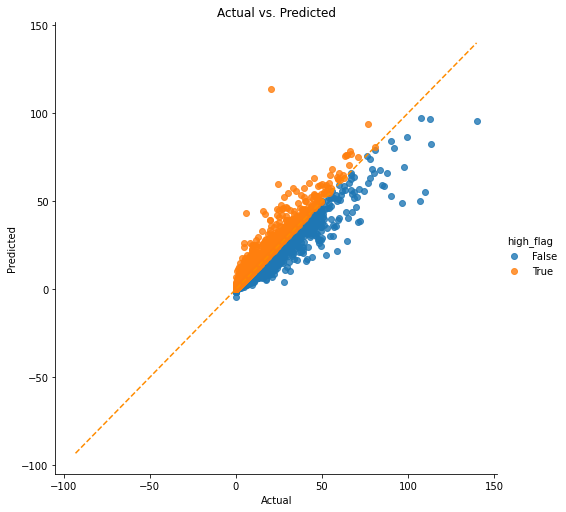

In [26]:
df_results=linear_assumption(model, X_test, y_test)

In [62]:
explainer = shap.Explainer(model.predict, X_test)

In [63]:
shap_values = explainer(X_test)

Permutation explainer: 5122it [08:47,  9.52it/s]                                                                        


### feature contribution in single prediction

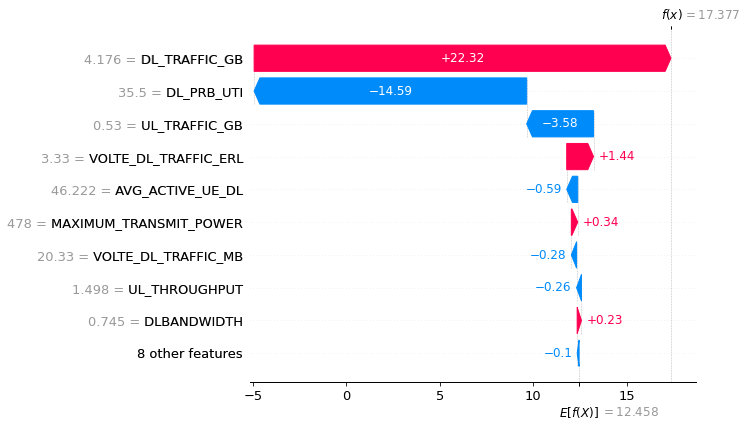

In [64]:
shap.plots.waterfall(shap_values[0])

### case when target is zero

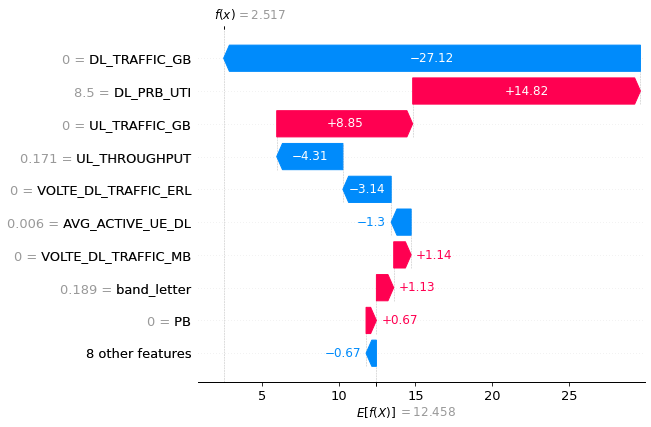

In [66]:

shap.plots.waterfall(shap_values[3])

## feature contribution in model

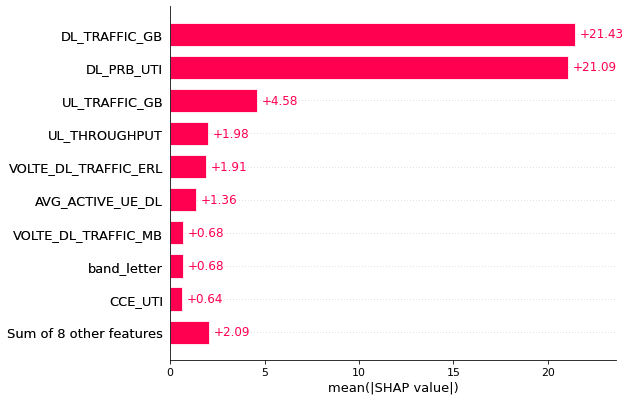

In [80]:
shap.plots.bar(shap_values)

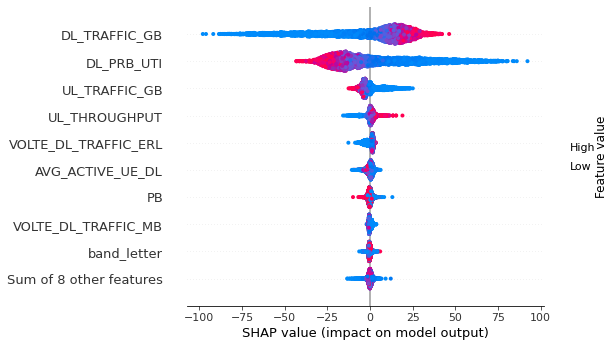

In [82]:
shap.plots.beeswarm(shap_values)

### training with all features when excluding BW_UTI=0

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=0)

## feature selection 

In [35]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

DL_PRB_UTI                0.500601
AVG_ACTIVE_UE_DL          0.436250
UL_TRAFFIC_GB             0.390757
CCE_UTI                   0.370023
DL_TRAFFIC_GB             0.361169
UL_THROUGHPUT             0.337309
band                      0.275426
VOLTE_DL_TRAFFIC_MB       0.224177
DLBANDWIDTH               0.215496
VOLTE_UL_TRAFFIC_MB       0.211967
VOLTE_DL_TRAFFIC_ERL      0.197724
band_letter               0.173339
MAXIMUM_TRANSMIT_POWER    0.097914
REFERENCESIGNALPWR        0.096357
PB                        0.067661
MAXMIMORANKPARA           0.032714
PAPCOFF                   0.006396
dtype: float64

In [36]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [38]:
mse = mean_squared_error(y_test, y_predict)

In [39]:
mse

22.249470260346843

### choosing top features

In [30]:
X_train_top = X_train[['DL_PRB_UTI','CCE_UTI','AVG_ACTIVE_UE_DL','UL_TRAFFIC_GB','band','DL_TRAFFIC_GB']]
X_test_top =  X_test[['DL_PRB_UTI','CCE_UTI','AVG_ACTIVE_UE_DL','UL_TRAFFIC_GB','band','DL_TRAFFIC_GB']]

In [31]:
model = xgb.XGBRegressor()
model.fit(X_train_top, y_train)
y_predict = model.predict(X_test_top)

In [32]:
mse = mean_squared_error(y_test, y_predict)

In [34]:
mse

23.942740676294836

In [33]:
r2 = r2_score(y_test,y_predict)

In [35]:
r2

0.8702421417464004

In [48]:
mse

23.942740676294836

In [36]:
X_train_top = X_train[['DL_PRB_UTI','UL_THROUGHPUT','AVG_ACTIVE_UE_DL','UL_TRAFFIC_GB','band','DL_TRAFFIC_GB']]
X_test_top =  X_test[['DL_PRB_UTI','UL_THROUGHPUT','AVG_ACTIVE_UE_DL','UL_TRAFFIC_GB','band','DL_TRAFFIC_GB']]

In [37]:
model = xgb.XGBRegressor()
model.fit(X_train_top, y_train)
y_predict = model.predict(X_test_top)

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


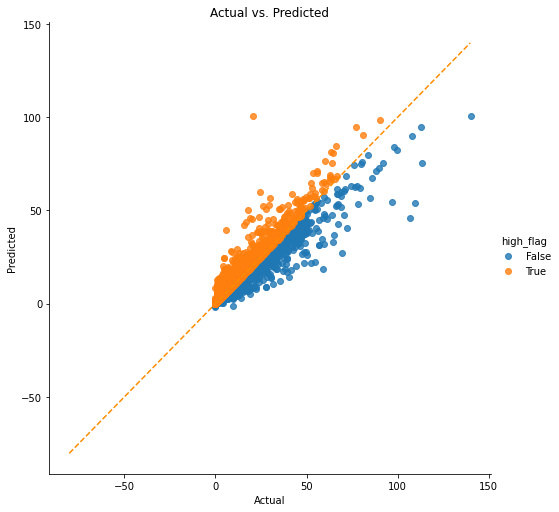

In [42]:
df_results=linear_assumption(model, X_test_top, y_test)

In [38]:
mse = mean_squared_error(y_test, y_predict)

In [39]:
mse

22.182033623886184

In [40]:
r2=r2_score(y_test, y_predict)

In [41]:
r2

0.8797843064977713

In [ ]:
['DL_PRB_UTI','UL_THROUGHPUT','AVG_ACTIVE_UE_DL','UL_TRAFFIC_GB','band','DL_TRAFFIC_GB']

In [54]:
all_df = pd.merge(cells_kpis, cells_params, on = 'CELL_NAME')
all_df.drop(['DATE_ID_x', 'HOUR_ID_x', 'DATE_ID_y', 'HOUR_ID_y', 'SITE_ID', 'SITE_NENAME',
       'CELL_ID', 'MIMO_ADAPTIVE_SWITCH', 'FIXED_MIMO_MODE',  'ULBANDWIDTH','SPECTRUMCLOUDSWITCH'], axis = 1, inplace = True)
all_df.head()

,CELL_NAME,DL_TRAFFIC_GB,DL_THROUGHPUT,UL_THROUGHPUT,UL_TRAFFIC_GB,DL_PRB_UTI,CCE_UTI,VOLTE_DL_TRAFFIC_ERL,VOLTE_DL_TRAFFIC_MB,VOLTE_UL_TRAFFIC_MB,AVG_ACTIVE_UE_DL,MAXMIMORANKPARA,REFERENCESIGNALPWR,PB,DLBANDWIDTH,PAPCOFF,MAXIMUM_TRANSMIT_POWER
0,LALX3634_56348_N_H_T8-3,0.0063,3.1673,3.1308,0.0024,2.308,3.75,0.00,0.00,0.00,0.178,Rank4,152,1,20M,0.0,430.0
1,LALX3639_56396_N_H_T8-1,1.9485,21.0800,3.3449,0.2171,19.851,14.19,1.04,5.04,5.52,22.403,Rank4,182,1,20M,0.0,460.0
2,LALX3642_36426_N_H_G2-1,0.0000,0.0000,0.0000,0.0000,2.304,7.19,0.00,0.00,0.00,0.000,Rank2,182,0,10M,0.0,490.0
3,LALX3642_56421_S_H_D4-3,0.0000,0.0000,0.0000,0.0000,0.000,0.00,0.00,0.00,0.00,0.000,Rank2,152,0,20M,0.0,460.0
4,LALX3644_36441_N_H_D4-1,0.6732,41.8595,4.4317,0.0422,4.494,5.85,0.03,0.10,0.19,2.627,Rank2,170,0,20M,0.0,478.0


In [55]:
all_df['CELL_NAME'] = all_df['CELL_NAME'].str.replace('-', '_')
all_df['band'] = all_df["CELL_NAME"].str.split('_').str.get(-2)

array(['T8', 'G2', 'D4', 'G1', 'U1', 'D7', 'T4', 'U2', 'D3', nan, 'D6',
       'D8', 'G3', 'D5', 'D2'], dtype=object)

In [57]:
all_df['band_letter'] = all_df['band'].str.get(0)

In [58]:
all_df.dropna(axis=0,inplace=True)
all_df.drop_duplicates(inplace=True)


In [59]:
all_df=all_df[all_df['band'].str.len() == 2]

In [60]:
categorical = all_df.select_dtypes(['object'])
numerical = all_df.select_dtypes(['float64','int64'])

In [61]:
target= all_df['DL_THROUGHPUT']
numerical.drop(['DL_THROUGHPUT'],axis=1, inplace = True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
categorical.columns

Index(['CELL_NAME', 'MAXMIMORANKPARA', 'DLBANDWIDTH', 'band', 'band_letter'], dtype='object')

In [63]:
numerical.columns

Index(['DL_TRAFFIC_GB', 'UL_THROUGHPUT', 'UL_TRAFFIC_GB', 'DL_PRB_UTI',
       'CCE_UTI', 'VOLTE_DL_TRAFFIC_ERL', 'VOLTE_DL_TRAFFIC_MB',
       'VOLTE_UL_TRAFFIC_MB', 'AVG_ACTIVE_UE_DL', 'REFERENCESIGNALPWR', 'PB',
       'PAPCOFF', 'MAXIMUM_TRANSMIT_POWER'],
      dtype='object')

In [64]:
numerical_features= numerical[['DL_TRAFFIC_GB', 'UL_THROUGHPUT', 'UL_TRAFFIC_GB', 'DL_PRB_UTI','VOLTE_DL_TRAFFIC_ERL']]
categorical_features= categorical['band_letter']
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=all_df[feature], target)
    plt.title(f'Box Plot: {feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

# Plot scatter plots for numerical features
numerical_features = ['Numeric']
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=all_df[feature], target)
    plt.title(f'Scatter Plot: {feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

SyntaxError: positional argument follows keyword argument (2150790943.py, line 5)

In [2]:
jupyter nbconvert --to html --TemplateExporter.exclude_input=True "/home/U_AA/throughput_opt/shap analysis.ipynb"


SyntaxError: invalid syntax (1399896480.py, line 1)

In [3]:
all_df

NameError: name 'all_df' is not defined